In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")
sys.path.append("../src/tests")

In [3]:
import clustering as clstr
import bout.assembly as bt
import plot as bt_plt
import test_activity_metric_functions as test_actvt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS

from cli import get_file_paths
import pipeline

In [4]:
def plot_activity_index_time_blocks(ax, audio_features, data_params):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']
    index_time_block = data_params['index_time_block_in_secs']

    cycle_length = index_time_block
    time_on = index_time_block

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='pink', facecolor=None, alpha=0.1)
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='pink', facecolor=None, alpha=0.1)
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='pink', facecolor=None, alpha=0.1)
                window_count+=1
            ax.add_patch(rect)

def plot_bout_info(ax, audio_features, plot_bouts):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    for i, row in plot_bouts.iterrows():
        if duration < 600:
            plt.text(x=(row['start_time'] - start + (row['bout_duration_in_secs']/5))*(fs/2), y=min((row['high_freq']+2000)/(fs/2), 9/10), 
                                s=f"{round(row['bout_duration_in_secs'], 2)}s", color='pink', weight='bold', fontsize=14)
            plt.text(x=(row['start_time'] - start + (row['bout_duration_in_secs']/5))*(fs/2), y=min((row['high_freq']+12000)/(fs/2), 9/10), 
                                s=f"{round(row['number_of_dets'], 2)} dets", color='pink', weight='bold', fontsize=14)
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['bout_duration_in_secs'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor=FREQUENCY_COLOR_MAPPINGS[row['freq_group']], facecolor='none', alpha=0.8)
        ax.add_patch(rect)
   
def plot_recording_periods(ax, audio_features, data_params):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
            ax.add_patch(rect)

In [5]:
def plot_raw_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params, data_params):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BatDetect2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detections')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)

    legend_patches = []
    for group in bout_params.keys():
        if group != 'site_key':
            group_tag = group.split('_')[0]
            group_patch = patches.Patch(facecolor=FREQUENCY_COLOR_MAPPINGS[group_tag], edgecolor='k', label=f'BCI = {round(bout_params[group], 2)}ms')
            legend_patches += [group_patch]
    plot_bout_info(ax, audio_features, plot_bouts)

    dc_tag = data_params['cur_dc_tag']
    cycle_length_in_mins = int(dc_tag.split('of')[1])
    data_params['index_time_block_in_secs'] = 5

    bout_duration_per_cycle = actvt.get_bout_duration_per_cycle(plot_bouts.copy(), cycle_length_in_mins)
    plot_recording_periods_with_bout_duration(ax, audio_features, data_params, np.round(bout_duration_per_cycle,2))
    num_dets_per_cycle = actvt.get_number_of_detections_per_cycle(plot_dets.copy(), cycle_length_in_mins)
    plot_recording_periods_with_num_calls(ax, audio_features, data_params, num_dets_per_cycle)
    inds_per_cycle = actvt.get_activity_index_per_cycle(plot_dets.copy(), data_params)
    plot_activity_index_time_blocks(ax, audio_features, data_params)
    plot_recording_periods_with_activity_inds(ax, audio_features, data_params, inds_per_cycle)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=14, ncol=int(len(legend_patches)**0.5), loc='upper right')

    plt.tight_layout()
    plt.show()


def plot_recording_periods_with_num_calls(ax, audio_features, data_params, num_dets_per_cycle):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/4
                plt.text(x=text_loc*fs/2, y=0.55, s=f"{num_dets_per_cycle[window_count]} calls", color='pink', weight='bold', fontsize=14)
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) +(min(time_on, (start+duration) - window_start)/4)
                plt.text(x=text_loc*fs/2, y=0.55, s=f"{num_dets_per_cycle[window_count]} calls", color='pink', weight='bold', fontsize=14)
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) + (time_on/4)
                plt.text(x=text_loc*fs/2, y=0.55, s=f"{num_dets_per_cycle[window_count]} calls", color='pink', weight='bold', fontsize=14)
                window_count+=1
            ax.add_patch(rect)

def plot_recording_periods_with_bout_duration(ax, audio_features, data_params, bout_duration_per_cycle):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/4
                plt.text(x=text_loc*fs/2, y=0.65, s=f"{bout_duration_per_cycle[window_count]}s of bouts", color='pink', weight='bold', fontsize=14)
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) + (min(time_on, (start+duration) - window_start)/4)
                plt.text(x=text_loc*fs/2, y=0.65, s=f"{bout_duration_per_cycle[window_count]}s of bouts", color='pink', weight='bold', fontsize=14)
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) + (time_on/4)
                plt.text(x=text_loc*fs/2, y=0.65, s=f"{bout_duration_per_cycle[window_count]}s of bouts", color='pink', weight='bold', fontsize=14)
                window_count+=1
            ax.add_patch(rect)

def plot_recording_periods_with_activity_inds(ax, audio_features, data_params, inds_per_cycle):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/4
                plt.text(x=text_loc*fs/2, y=0.45, s=f"{inds_per_cycle[window_count]} AI", color='pink', weight='bold', fontsize=14)
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
                text_loc =  (window_start-start) +(min(time_on, (start+duration) - window_start)/4)
                plt.text(x=text_loc*fs/2, y=0.45, s=f"{inds_per_cycle[window_count]} AI", color='pink', weight='bold', fontsize=14)
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
                text_loc =  (window_start-start) + (time_on/4)
                plt.text(x=text_loc*fs/2, y=0.45, s=f"{inds_per_cycle[window_count]} AI", color='pink', weight='bold', fontsize=14)
                window_count+=1
            ax.add_patch(rect)

In [6]:
def plot_normalized_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params, data_params):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BatDetect2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detections')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)

    legend_patches = []
    for group in bout_params.keys():
        if group != 'site_key':
            group_tag = group.split('_')[0]
            group_patch = patches.Patch(facecolor=FREQUENCY_COLOR_MAPPINGS[group_tag], edgecolor='k', label=f'BCI = {round(bout_params[group], 2)}ms')
            legend_patches += [group_patch]
    plot_bout_info(ax, audio_features, plot_bouts)

    dc_tag = data_params['cur_dc_tag']
    cycle_length_in_mins = int(dc_tag.split('of')[1])
    data_params['index_time_block_in_secs'] = 5

    bout_dur_per_cycle = actvt.get_bout_duration_per_cycle(plot_bouts.copy(), cycle_length_in_mins)
    btp_per_cycle = actvt.get_btp_per_time_on(bout_dur_per_cycle, data_params['time_on_in_secs'])
    plot_recording_periods_with_btp(ax, audio_features, data_params, np.round(btp_per_cycle,2))
    num_dets_per_cycle = actvt.get_number_of_detections_per_cycle(plot_dets.copy(), cycle_length_in_mins)
    callrate_per_cycle = actvt.get_metric_per_time_on(num_dets_per_cycle, cycle_length_in_mins)
    plot_recording_periods_with_callrate(ax, audio_features, data_params, np.round(callrate_per_cycle,2))
    blocks_per_cycle = actvt.get_activity_index_per_cycle(plot_dets.copy(), data_params)
    inds_percent_per_cycle = actvt.get_activity_index_per_time_on_index(blocks_per_cycle, data_params)
    plot_activity_index_time_blocks(ax, audio_features, data_params)
    plot_recording_periods_with_activity_inds_percent(ax, audio_features, data_params, np.round(inds_percent_per_cycle,2))

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=14, ncol=int(len(legend_patches)**0.5), loc='upper right')

    plt.tight_layout()
    plt.show()


def plot_recording_periods_with_callrate(ax, audio_features, data_params, callrate_per_cycle):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/4
                plt.text(x=text_loc*fs/2, y=0.55, s=f"{callrate_per_cycle[window_count]} calls/min", color='pink', weight='bold', fontsize=14)
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) +(min(time_on, (start+duration) - window_start)/4)
                plt.text(x=text_loc*fs/2, y=0.55, s=f"{callrate_per_cycle[window_count]} calls/min", color='pink', weight='bold', fontsize=14)
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) + (time_on/4)
                plt.text(x=text_loc*fs/2, y=0.55, s=f"{callrate_per_cycle[window_count]} calls/min", color='pink', weight='bold', fontsize=14)
                window_count+=1
            ax.add_patch(rect)

def plot_recording_periods_with_btp(ax, audio_features, data_params, btp_per_cycle):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/4
                plt.text(x=text_loc*fs/2, y=0.65, s=f"{btp_per_cycle[window_count]}% BTP", color='pink', weight='bold', fontsize=14)
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) + (min(time_on, (start+duration) - window_start)/4)
                plt.text(x=text_loc*fs/2, y=0.65, s=f"{btp_per_cycle[window_count]}% BTP", color='pink', weight='bold', fontsize=14)
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) + (time_on/4)
                plt.text(x=text_loc*fs/2, y=0.65, s=f"{btp_per_cycle[window_count]}% BTP", color='pink', weight='bold', fontsize=14)
                window_count+=1
            ax.add_patch(rect)

def plot_recording_periods_with_activity_inds_percent(ax, audio_features, data_params, inds_per_cycle):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/4
                plt.text(x=text_loc*fs/2, y=0.45, s=f"{inds_per_cycle[window_count]}% AI", color='pink', weight='bold', fontsize=14)
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
                text_loc =  (window_start-start) +(min(time_on, (start+duration) - window_start)/4)
                plt.text(x=text_loc*fs/2, y=0.45, s=f"{inds_per_cycle[window_count]}% AI", color='pink', weight='bold', fontsize=14)
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
                text_loc =  (window_start-start) + (time_on/4)
                plt.text(x=text_loc*fs/2, y=0.45, s=f"{inds_per_cycle[window_count]}% AI", color='pink', weight='bold', fontsize=14)
                window_count+=1
            ax.add_patch(rect)

In [7]:
input_file1 = Path('../../Downloads/20220730_103000.WAV')


filename = input_file1.name
human_file_dets = pd.read_csv(f'../../Downloads/{filename.split(".")[0]}.txt', sep='\t')
human_file_dets = human_file_dets.loc[human_file_dets['View']=='Spectrogram 1']
human_file_dets.rename(columns={"Begin Time (s)": "start_time", 
                                "End Time (s)": "end_time",
                                "Low Freq (Hz)": "low_freq",
                                "High Freq (Hz)": "high_freq"}, inplace=True)
file_dts = pd.to_datetime(human_file_dets['input_file'], format='%Y%m%d_%H%M%S', exact=False).ffill()

anchor_start_times = file_dts + pd.to_timedelta(human_file_dets['start_time'].values.astype('float64'), unit='S')
anchor_end_times = file_dts + pd.to_timedelta(human_file_dets['end_time'].values.astype('float64'), unit='S') 
human_file_dets.insert(0, 'call_end_time', anchor_end_times)
human_file_dets.insert(0, 'call_start_time', anchor_start_times)
human_file_dets.insert(0, 'ref_time', anchor_start_times)
human_file_dets = human_file_dets.sort_values(by='call_start_time')
lf_human_dets = human_file_dets.loc[(human_file_dets['low_freq']<=30000)&(human_file_dets['low_freq']>=18000)]

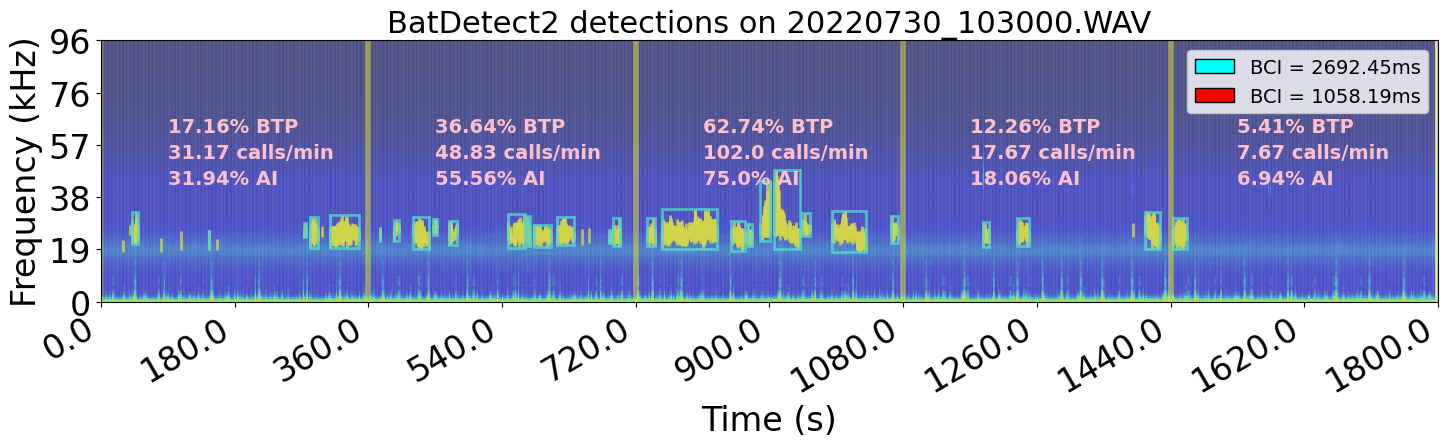

In [8]:
site_key = 'Central'
freq_key = ''

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = freq_key
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '6of6'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
file_paths = get_file_paths(data_params)

location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
bout_params = bt.get_bout_params_from_location(location_df, data_params)

file_path = Path('../../Downloads/20220730_103000.WAV')
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 1800
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params['use_threshold_to_group'] = False
pipeline_params['use_kmeans_to_group'] = True

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

dc_applied_df = ss.simulate_dutycycle_on_detections(lf_human_dets.copy(), data_params)
plot_dets = dc_applied_df.loc[np.logical_and(dc_applied_df['start_time'] >= start, dc_applied_df['end_time'] <= (start+duration))]
plot_dets.insert(0, 'freq_group', ['LF']*plot_dets.shape[0])
bout_metrics = bt.generate_bout_metrics_for_location_and_freq(plot_dets, data_params, bout_params)
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] >= start, bout_metrics['end_time'] <= (start+duration))]
plot_normalized_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params,  data_params)